In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Data preprocessing useful function
from sklearn.preprocessing import LabelEncoder
# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split
# ALgorithm
from sklearn import tree
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Functions for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sktime.performance_metrics.forecasting import median_relative_absolute_error

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df = df.drop(['Id'],axis=1)

In [5]:
basement_nan_str_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df[basement_nan_str_cols] = df[basement_nan_str_cols].fillna('NA')

garage_nan_str_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df[garage_nan_str_cols] = df[garage_nan_str_cols].fillna('NA')

In [6]:
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearRemodAdd'])

In [7]:
df = df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','YearBuilt','YearRemodAdd'],axis=1)

In [8]:
dummied_df=pd.get_dummies(df,columns=['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig',
                                     'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                                     'OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                                      'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
                                      'BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC',
                                      'CentralAir','Electrical','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                                      'BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd','Functional','Fireplaces',
                                      'GarageType','GarageFinish','GarageCars','GarageQual','GarageCond','PavedDrive',
                                      'SaleType','SaleCondition'])
dummied_df

,LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,856,856,854,0,1710,2003.0,548,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,0.0,1262,1262,0,0,1262,1976.0,460,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,162.0,920,920,866,0,1786,2001.0,608,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,0.0,756,961,756,0,1717,1998.0,642,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,350.0,1145,1145,1053,0,2198,2000.0,836,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,0.0,953,953,694,0,1647,1999.0,460,...,0,0,0,1,0,0,0,0,1,0
1456,85.0,13175,119.0,1542,2073,0,0,2073,1978.0,500,...,0,0,0,1,0,0,0,0,1,0
1457,66.0,9042,0.0,1152,1188,1152,0,2340,1941.0,252,...,0,0,0,1,0,0,0,0,1,0
1458,68.0,9717,0.0,1078,1078,0,0,1078,1950.0,240,...,0,0,0,1,0,0,0,0,1,0


In [9]:
corr_matrix = dummied_df.corr()

In [10]:
important_num_cols = list(dummied_df.corr()["SalePrice"][(dummied_df.corr()["SalePrice"]>0.40) | (dummied_df.corr()["SalePrice"]<-0.40)].index)
#cat_cols = ["MSZoning", "Utilities","BldgType","Heating","KitchenQual","SaleCondition","LandSlope"]
#important_cols = important_num_cols + cat_cols

important_num_cols
derived_df = dummied_df[important_num_cols]

In [11]:
x = derived_df.drop(['SalePrice'],axis=1).copy()
y = derived_df['SalePrice'].copy()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
a = [2e-10,2e-6,2**8]
b = [2e-15,2e-10,2e-1]
c = [10,20,42]

rmse_1_1 = 0
rmse_1_2 = 0
rmse_1_3 = 0
rmse_2_1 = 0
rmse_2_2 = 0
rmse_2_3 = 0
rmse_3_1 = 0
rmse_3_2 = 0
rmse_3_3 = 0

for k in c:
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = k)
    for i in a:
        for j in b:
            model=SVR(kernel='rbf', C=i, epsilon=j)
            model.fit(x_validation,y_validation)
            
            validation_pred=model.predict(x_validation)
            rmse=mean_squared_error(y_validation,validation_pred,squared=False)

            if i==2e-10 and j==2e-15 and k==10:
                rmse_1_1 += rmse
            if i==2e-10 and j==2e-10 and k==10:
                rmse_1_2 += rmse
            if i==2e-10 and j==2e-1 and k==10:
                rmse_1_3 += rmse
            if i==2e-6 and j==2e-15 and k==10:
                rmse_2_1 += rmse
            if i==2e-6 and j==2e-10 and k==10:
                rmse_2_2 += rmse
            if i==2e-6 and j==2e-1 and k==10:
                rmse_2_3 += rmse
            if i==2**8 and j==2e-15 and k==10:
                rmse_3_1 += rmse
            if i==2**8 and j==2e-10 and k==10:
                rmse_3_2 += rmse
            if i==2**8 and j==2e-1 and k==10:
                rmse_3_3 += rmse
                
print('RMSE:')
print('rmse_2_5:',round((rmse_1_1),2))
print('rmse_2_20:',round((rmse_1_2),2))
print('rmse_2_100:',round((rmse_1_3),2))
print('rmse_6_5:',round((rmse_2_1),2))
print('rmse_6_20:',round((rmse_2_2),2))
print('rmse_6_100:',round((rmse_2_3),2))
print('rmse_8_5:',round((rmse_3_1),2))
print('rmse_8_20:',round((rmse_3_2),2))
print('rmse_8_100:',round((rmse_3_3),2))

RMSE:
rmse_2_5: 75312.43
rmse_2_20: 75312.43
rmse_2_100: 75312.39
rmse_6_5: 75312.43
rmse_6_20: 75312.43
rmse_6_100: 75312.39
rmse_8_5: 73357.23
rmse_8_20: 73357.23
rmse_8_100: 73357.23


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
a = [2e-10,2e-6,2**8]
b = [2e-15,2e-10,2e-1]
c = [10,20,42]

rmse_1_1 = 0
rmse_1_2 = 0
rmse_1_3 = 0
rmse_2_1 = 0
rmse_2_2 = 0
rmse_2_3 = 0
rmse_3_1 = 0
rmse_3_2 = 0
rmse_3_3 = 0

for k in c:
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = k)
    for i in a:
        for j in b:
            model=SVR(kernel='rbf', C=i, epsilon=j)
            model.fit(x_validation,y_validation)
            
            validation_pred=model.predict(x_validation)
            rmse=mean_squared_error(y_validation,validation_pred,squared=False)

            if i==2e-10 and j==2e-15 and k==20:
                rmse_1_1 += rmse
            if i==2e-10 and j==2e-10 and k==20:
                rmse_1_2 += rmse
            if i==2e-10 and j==2e-1 and k==20:
                rmse_1_3 += rmse
            if i==2e-6 and j==2e-15 and k==20:
                rmse_2_1 += rmse
            if i==2e-6 and j==2e-10 and k==20:
                rmse_2_2 += rmse
            if i==2e-6 and j==2e-1 and k==20:
                rmse_2_3 += rmse
            if i==2**8 and j==2e-15 and k==20:
                rmse_3_1 += rmse
            if i==2**8 and j==2e-10 and k==20:
                rmse_3_2 += rmse
            if i==2**8 and j==2e-1 and k==20:
                rmse_3_3 += rmse
                
print('RMSE:')
print('rmse_2_5:',round((rmse_1_1),2))
print('rmse_2_20:',round((rmse_1_2),2))
print('rmse_2_100:',round((rmse_1_3),2))
print('rmse_6_5:',round((rmse_2_1),2))
print('rmse_6_20:',round((rmse_2_2),2))
print('rmse_6_100:',round((rmse_2_3),2))
print('rmse_8_5:',round((rmse_3_1),2))
print('rmse_8_20:',round((rmse_3_2),2))
print('rmse_8_100:',round((rmse_3_3),2))

RMSE:
rmse_2_5: 76209.7
rmse_2_20: 76209.7
rmse_2_100: 76209.76
rmse_6_5: 76209.7
rmse_6_20: 76209.7
rmse_6_100: 76209.76
rmse_8_5: 74286.22
rmse_8_20: 74286.22
rmse_8_100: 74286.22


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
a = [2e-10,2e-6,2**8]
b = [2e-15,2e-10,2e-1]
c = [10,20,42]

rmse_1_1 = 0
rmse_1_2 = 0
rmse_1_3 = 0
rmse_2_1 = 0
rmse_2_2 = 0
rmse_2_3 = 0
rmse_3_1 = 0
rmse_3_2 = 0
rmse_3_3 = 0

for k in c:
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.2, random_state = k)
    for i in a:
        for j in b:
            model=SVR(kernel='rbf', C=i, epsilon=j)
            model.fit(x_validation,y_validation)
            
            validation_pred=model.predict(x_validation)
            rmse=mean_squared_error(y_validation,validation_pred,squared=False)

            if i==2e-10 and j==2e-15 and k==42:
                rmse_1_1 += rmse
            if i==2e-10 and j==2e-10 and k==42:
                rmse_1_2 += rmse
            if i==2e-10 and j==2e-1 and k==42:
                rmse_1_3 += rmse
            if i==2e-6 and j==2e-15 and k==42:
                rmse_2_1 += rmse
            if i==2e-6 and j==2e-10 and k==42:
                rmse_2_2 += rmse
            if i==2e-6 and j==2e-1 and k==42:
                rmse_2_3 += rmse
            if i==2**8 and j==2e-15 and k==42:
                rmse_3_1 += rmse
            if i==2**8 and j==2e-10 and k==42:
                rmse_3_2 += rmse
            if i==2**8 and j==2e-1 and k==42:
                rmse_3_3 += rmse
                
print('RMSE:')
print('rmse_2_5:',round((rmse_1_1),2))
print('rmse_2_20:',round((rmse_1_2),2))
print('rmse_2_100:',round((rmse_1_3),2))
print('rmse_6_5:',round((rmse_2_1),2))
print('rmse_6_20:',round((rmse_2_2),2))
print('rmse_6_100:',round((rmse_2_3),2))
print('rmse_8_5:',round((rmse_3_1),2))
print('rmse_8_20:',round((rmse_3_2),2))
print('rmse_8_100:',round((rmse_3_3),2))

RMSE:
rmse_2_5: 88343.39
rmse_2_20: 88343.39
rmse_2_100: 88343.39
rmse_6_5: 88343.39
rmse_6_20: 88343.39
rmse_6_100: 88343.39
rmse_8_5: 86410.04
rmse_8_20: 86410.04
rmse_8_100: 86410.04


In [18]:
#三次平均
mse_2_5 = [75312.43, 76209.7, 88343.39]
mse_2_20 = [75312.43, 76209.7, 88343.39]
mse_2_100 = [75312.39, 76209.76, 88343.39]
mse_6_5 = [75312.43, 76209.7, 88343.39]
mse_6_20 = [75312.43, 76209.7, 88343.39]
mse_6_100 = [75312.39, 76209.76, 88343.39]
mse_8_5 = [73357.23, 74286.22, 86410.04]
mse_8_20 = [73357.23, 74286.22, 86410.04]
mse_8_100 = [73357.23, 74286.22, 86410.04]

print('mse_2_5:',round(np.mean(mse_2_5),2),'+/-',round(np.std(mse_2_5),2))
print('mse_2_20:',round(np.mean(mse_2_20),2),'+/-',round(np.std(mse_2_20),2))
print('mse_2_100:',round(np.mean(mse_2_100),2),'+/-',round(np.std(mse_2_100),2))
print('mse_6_5:',round(np.mean(mse_6_5),2),'+/-',round(np.std(mse_6_5),2))
print('mse_6_20:',round(np.mean(mse_6_20),2),'+/-',round(np.std(mse_6_20),2))
print('mse_6_100:',round(np.mean(mse_6_100),2),'+/-',round(np.std(mse_6_100),2))
print('mse_8_5:',round(np.mean(mse_8_5),2),'+/-',round(np.std(mse_8_5),2))
print('mse_8_20:',round(np.mean(mse_8_20),2),'+/-',round(np.std(mse_8_20),2))
print('mse_8_100:',round(np.mean(mse_8_100),2),'+/-',round(np.std(mse_8_100),2))

mse_2_5: 79955.17 +/- 5942.67
mse_2_20: 79955.17 +/- 5942.67
mse_2_100: 79955.18 +/- 5942.66
mse_6_5: 79955.17 +/- 5942.67
mse_6_20: 79955.17 +/- 5942.67
mse_6_100: 79955.18 +/- 5942.66
mse_8_5: 78017.83 +/- 5946.3
mse_8_20: 78017.83 +/- 5946.3
mse_8_100: 78017.83 +/- 5946.3


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
model=SVR(kernel='rbf', C=2e-10, epsilon=2e-15)
model.fit(x_train,y_train)
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

y_pred_benchmark = train_pred*1.1
train_mse = mean_squared_error(y_train,train_pred,squared=True)
train_rmse = mean_squared_error(y_train,train_pred, squared=False)
train_mape = mean_absolute_percentage_error(y_train,train_pred)
train_smape = 2*np.mean(np.abs(train_pred-y_train)/(np.abs(train_pred)+np.abs(y_train)))*100
train_mae = mean_absolute_error(y_train, train_pred)
train_mdrae = median_relative_absolute_error(y_train, train_pred, y_pred_benchmark=y_pred_benchmark)

y_pred_benchmark = test_pred*1.1
test_mse = mean_squared_error(y_test,test_pred,squared=True)
test_rmse = mean_squared_error(y_test,test_pred, squared=False)
test_mape = mean_absolute_percentage_error(y_test,test_pred)
test_smape = 2*np.mean(np.abs(test_pred-y_test)/(np.abs(test_pred)+np.abs(y_test)))*100
test_mae = mean_absolute_error(y_test, test_pred)
test_mdrae = median_relative_absolute_error(y_test, test_pred, y_pred_benchmark=y_pred_benchmark)

print('train_mse : ', np.round(train_mse,2))
print('train_rmse: ', np.round(train_rmse,2))
print('train_mape: ', np.round(train_mape,2))
print('train_smape: ', np.round(train_smape,2))
print('train_mae: ', np.round(train_mae,2))
print('train_mdrae: ', np.round(train_mdrae,2))
print('')
print('test_mse : ', np.round(test_mse,2))
print('test_rmse: ', np.round(test_rmse,2))
print('test_mape: ', np.round(test_mape,2))
print('test_smape: ', np.round(test_smape,2))
print('test_mae: ', np.round(test_mae,2))
print('test_mdrae: ', np.round(test_mdrae,2))

train_mse :  6474117070.31
train_rmse:  80461.9
train_mape:  0.32
train_smape:  30.21
train_mae:  55528.14
train_mdrae:  0.82

test_mse :  7243320956.2
test_rmse:  85107.7
test_mape:  0.3
test_smape:  29.5
test_mae:  55555.74
test_mdrae:  0.83


In [20]:
def generate_index(amount):
    index_list=[]
    for i in range(0,amount):
        idx=i+1
        index_list.append(idx)
    return(index_list)

In [21]:
results=pd.DataFrame({'Y_test_true':y_test,'Y_test_predict':test_pred})
results['count'] = generate_index(amount=len(y_test))
results

,Y_test_true,Y_test_predict,count
529,200624,163000.0,1
491,133000,163000.0,2
459,110000,163000.0,3
279,192000,163000.0,4
655,88000,163000.0,5
...,...,...,...
326,324000,163000.0,288
440,555000,163000.0,289
1387,136000,163000.0,290
1323,82500,163000.0,291


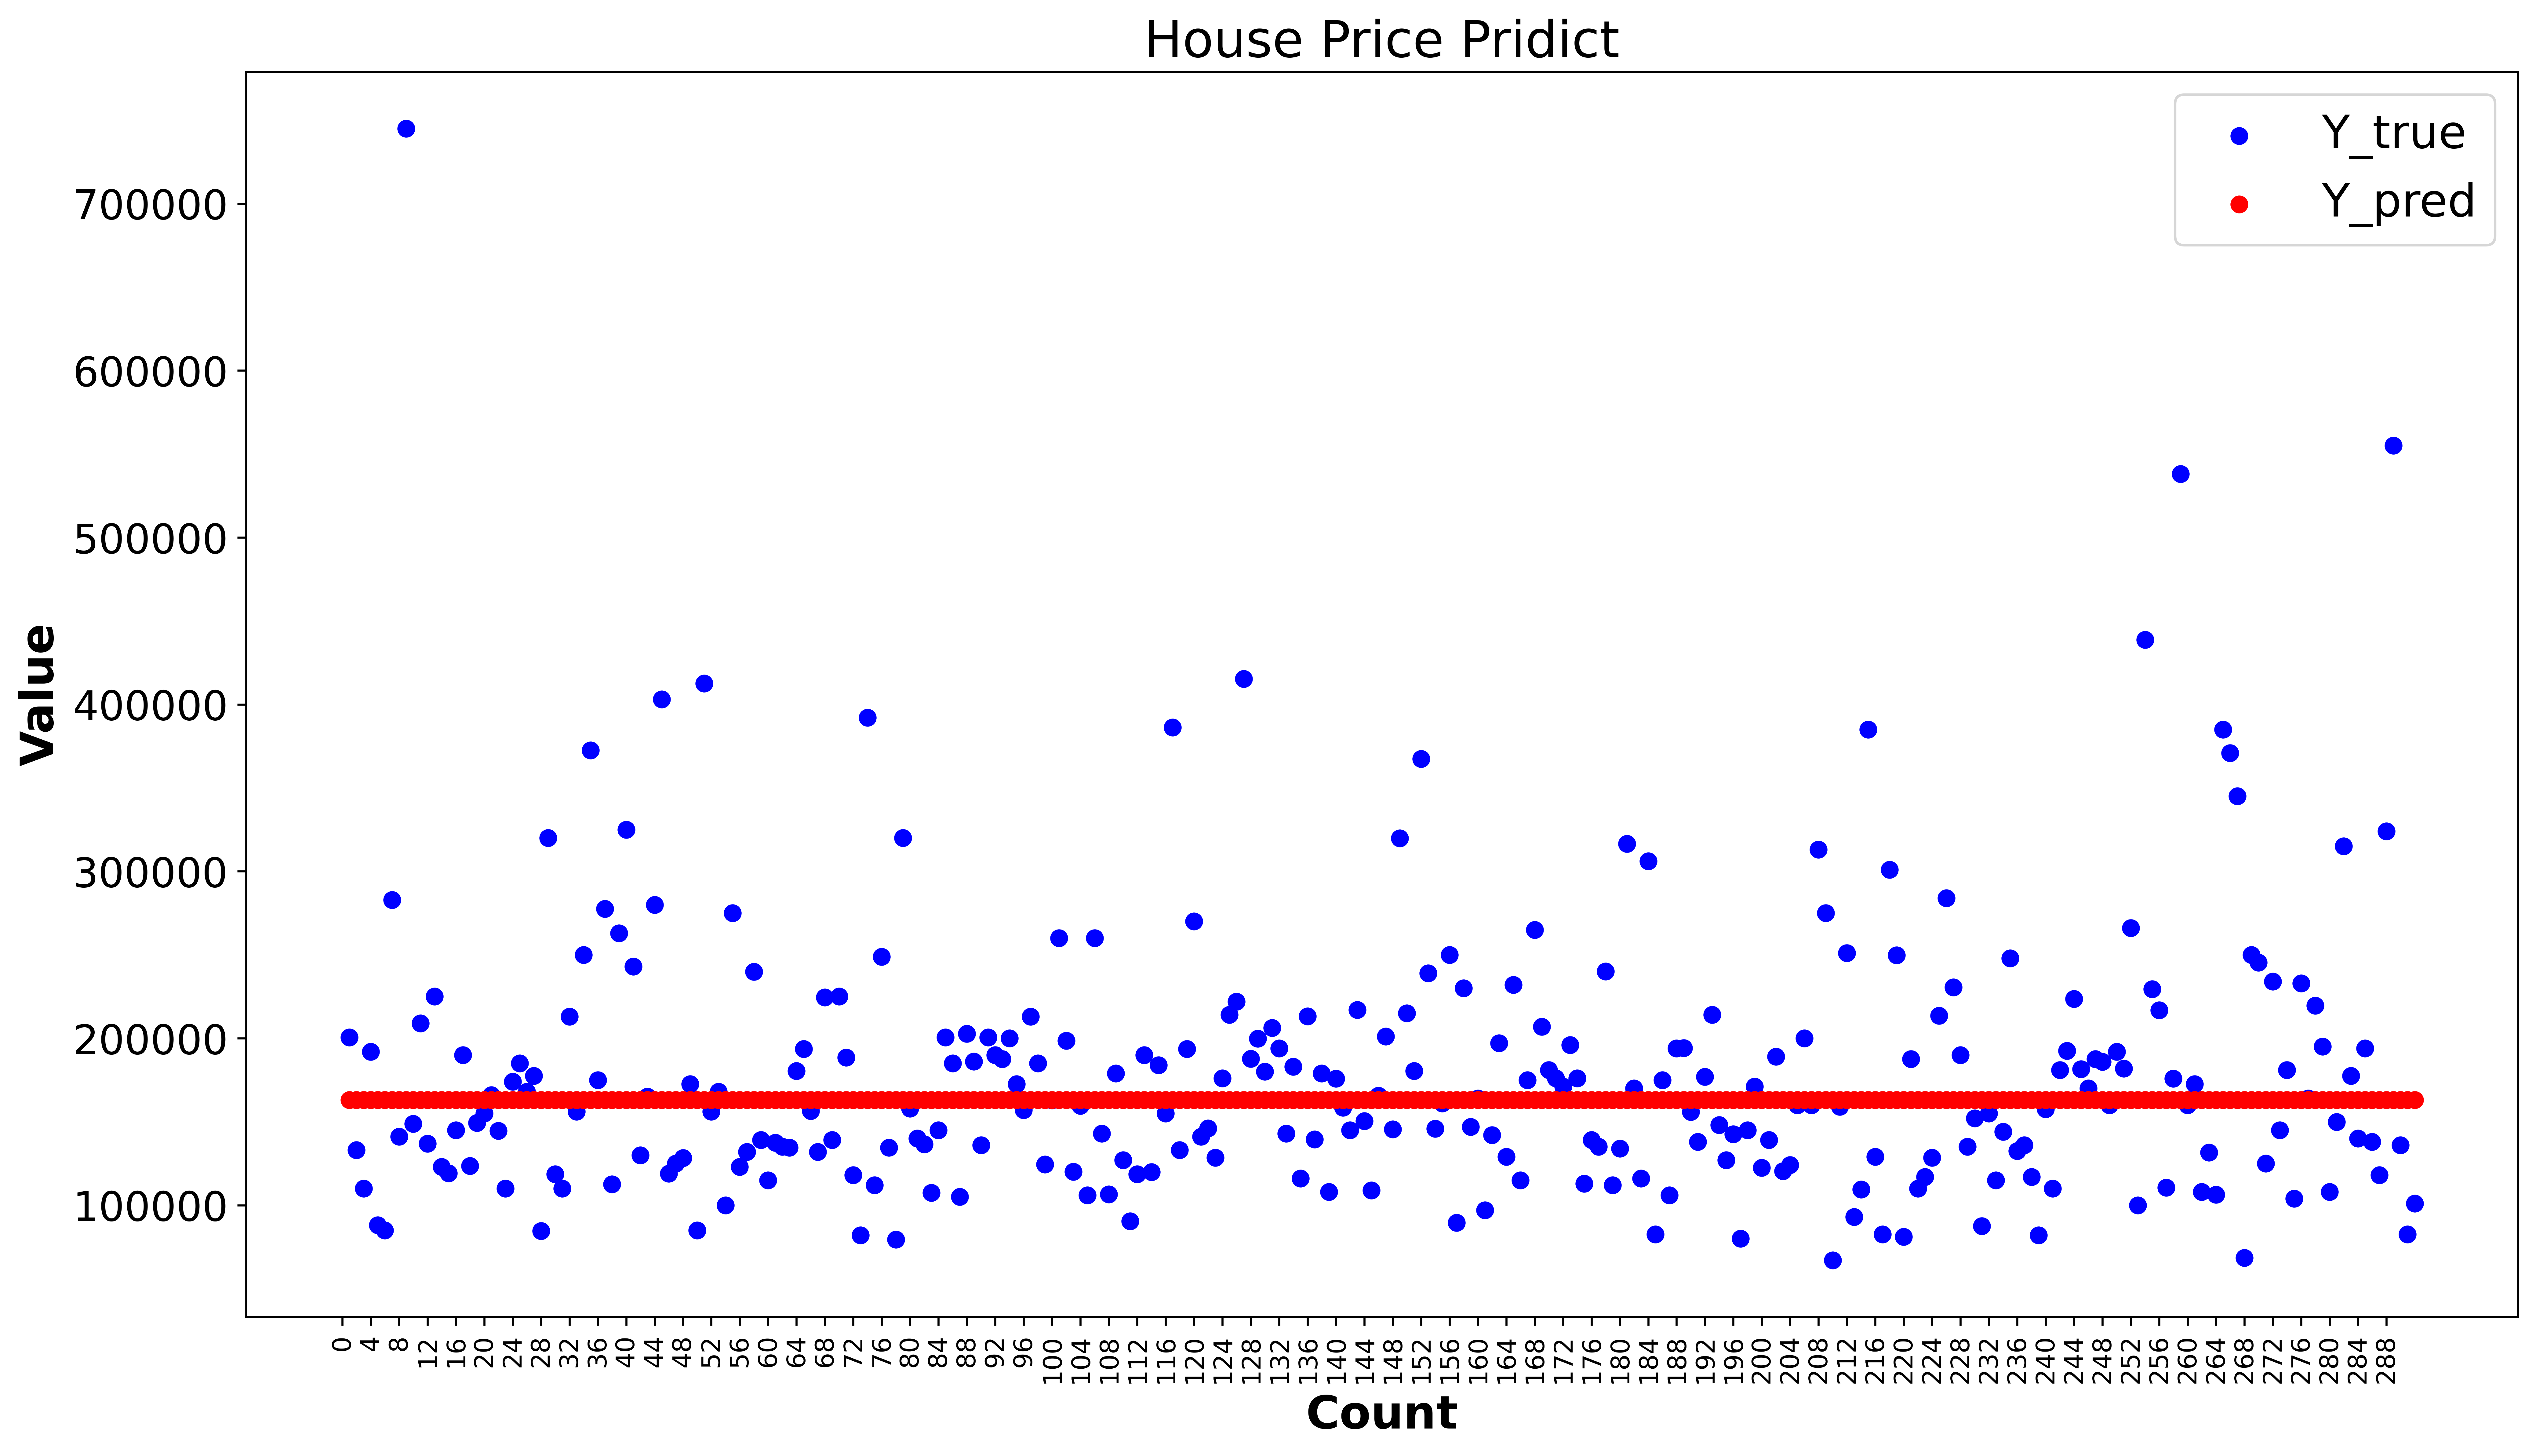

In [22]:
plt.figure(figsize=(16,9),dpi=600)
plt.title('House Price Pridict',fontsize=20)
plt.xlabel('Count',fontsize=18,weight='bold')
plt.ylabel('Value',fontsize=18,weight='bold')
plt.scatter(results.iloc[0:292,2],results.iloc[0:292,0],color='blue',label='Y_true')
plt.scatter(results.iloc[0:292,2],results.iloc[0:292,1],color='red',label='Y_pred')
plt.legend(loc=1,fontsize=18)
#plt.ylim(0,30)
#plt.xlim(0,21)
plt.xticks(np.arange(0, 292, 4), rotation ='vertical')
plt.yticks(fontsize=16)
plt.show()